# Burnup with material extraction

Extention/testbed of MIDN Cullinan's notebook

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
import xml.etree.ElementTree as et

In [21]:
# fuel uranium dioxode (PNNL)

# specify material ID's unlikely to be overwritten by the code
fuel = openmc.Material(name='uo2',material_id=1000)
fuel.set_density('g/cc',10.96)
fuel.add_nuclide('U234', 0.000090, 'ao')
fuel.add_nuclide('U235', 0.010124, 'ao')
fuel.add_nuclide('U236', 0.000046, 'ao')
fuel.add_nuclide('U238', 0.323072, 'ao')
fuel.add_element('O', 0.666667, 'ao')

clad = openmc.Material(name='Zirc4',material_id=2000)
clad.set_density('g/cc', 6.56)
clad.add_element('O', 0.006790, 'ao')
clad.add_element('Cr', 0.001741, 'ao')
clad.add_element('Fe', 0.003242, 'ao')
clad.add_element('Zr', 0.977549, 'ao')
clad.add_element('Sn', 0.010677, 'ao')

water = openmc.Material(name='h2o',material_id=3000)
water.set_density('g/cc', 0.712)
water.add_element('H', 2)
water.add_element('O', 1)
water.add_s_alpha_beta('c_H_in_H2O')

materials = openmc.Materials([fuel, clad, water])
materials.export_to_xml()

/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1000.
  warn(msg, IDWarning)
/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2000.
  warn(msg, IDWarning)
/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3000.
  warn(msg, IDWarning)


## Create geometry
pincell geometry modeling internal PWR location

In [3]:
h_cell = 300; # height of pincell

r_fuel = 0.42; # fuel radius
r_pin = 0.45; # clad radius

P_D = 1.4; # pitch to diameter ratio
pitch = P_D*(2*r_pin);

fuel_temp = 900; # representaive fuel temperature (K)
mod_temp = 600; # moderator temp (K)

# fuel cylinder
fuel_cyl = openmc.model.RightCircularCylinder([0,0,-h_cell/2],h_cell,r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_cell;

# pin cylinder
pin_cyl = openmc.model.RightCircularCylinder([0,0,-(h_cell+(r_pin-r_fuel))/2],h_cell+(r_pin-r_fuel)*2,r_pin);

# pin cell container

core_cell = openmc.model.RectangularParallelepiped(-pitch/2,pitch/2,
                                                   -pitch/2,pitch/2,
                                                   -(h_cell+100)/2,(h_cell+100)/2,
                                                   boundary_type = "reflective");
fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;

clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +pin_cyl & - core_cell;
mod_cell.fill = water;
mod_cell.temperature = mod_temp;

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;

geometry.export_to_xml();

## Settings for Burnup Calculations

In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 250;
settings.inactive = 50;

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_cell/2),
                      upper_right = (r_fuel,r_fuel,h_cell/2),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;
settings.temperature['method']='interpolation';
settings.export_to_xml();

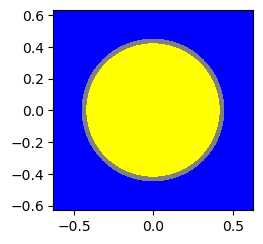

In [5]:
# create color dictionary
colors = {}
colors[water]='blue';
colors[fuel]='yellow';
colors[clad]='gray';

# plot pin cell universe to inspect geometry
root_univ.plot(width=(pitch,pitch),color_by='material',colors=colors);

## Create Depletion operator

In [6]:
model = openmc.model.Model(geometry,materials,settings)
operator = openmc.deplete.CoupledOperator(model,"chain_endfb71_pwr.xml");

# typical PWR power density = 30.5 W/gHM
# use truncated depletion for testing
power_density = [30.5,30.5,0,0]; # power density W/gHM 
# power 0 after 4.5 years with cooldown steps of a day, week, month to 2 years
days = 24*3600;
time_steps = [365*days, 365*days, 365*days, 365*days];
cecm = openmc.deplete.CECMIntegrator(operator,time_steps,power_density=power_density);

repeat_depletion = True


if(repeat_depletion):
    cecm.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/sblair/OMC_DATA/endfb71_hdf5/Al27.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading S32 from /home/sblair/OMC_DATA/endfb71_hdf5/S32.h5
 Reading S33 from /home/sblair/OMC_DATA/endfb71_hdf5/S33.h5
 Reading S34 from /home/sblair/OMC_DATA/endfb71_hdf5/S34.h5
 Reading S36 from /home/sblair/OMC_DATA/endfb71_hdf5/S36.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5
 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from

 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5
 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti50.h5
 Reading V50 from /home/sblair/OMC_DATA/endfb71_hdf5/V50.h5
 Reading V51 from /home/sblair/OMC_DATA/endfb71_hdf5/V51.h5
 Reading Mn55 from /home/sblair/OMC_DATA/endfb71_hdf5/Mn55.h5
 Reading Co58 

 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading Sr87 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr87.h5
 Reading Sr88 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr88.h5
 Reading Sr89 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr89.h5
 Reading

 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5


 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb7

          1200K
          2500K


 Reading Cd108 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd108.h5
 Reading Cd110 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn123.h5
 Reading Sn125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn125.h5
 Reading Sn126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/O

          1200K
          2500K


 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5


          1200K
          2500K


 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5
 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5
 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5


 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe123.h5
 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5


          1200K
          2500K


 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5
 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

 Reading Cf250 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf250.h5
 Reading Cf251 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5
 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5


          1200K


 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.29608
        2/1    1.29317
        3/1    1.32024
        4/1    1.30370
        5/1    1.30870
        6/1    1.31229
        7/1    1.31681
        8/1    1.32376
        9/1    1.33097
       10/1    1.28998
       11/1    1.31322
       12/1    1.31355
       13/1    1.29639
       14/1    1.31677
       15/1    1.32055
       16/1

      191/1    1.30814    1.31199 +/- 0.00104
      192/1    1.31641    1.31202 +/- 0.00103
      193/1    1.29237    1.31188 +/- 0.00103
      194/1    1.35163    1.31216 +/- 0.00106
      195/1    1.34239    1.31237 +/- 0.00108
      196/1    1.32601    1.31246 +/- 0.00107
      197/1    1.31797    1.31250 +/- 0.00107
      198/1    1.33087    1.31262 +/- 0.00107
      199/1    1.32056    1.31268 +/- 0.00106
      200/1    1.31381    1.31268 +/- 0.00105
      201/1    1.30236    1.31262 +/- 0.00105
      202/1    1.28405    1.31243 +/- 0.00106
      203/1    1.29807    1.31233 +/- 0.00106
      204/1    1.32324    1.31240 +/- 0.00105
      205/1    1.32612    1.31249 +/- 0.00105
      206/1    1.33305    1.31262 +/- 0.00105
      207/1    1.30782    1.31259 +/- 0.00104
      208/1    1.31145    1.31259 +/- 0.00104
      209/1    1.31213    1.31258 +/- 0.00103
      210/1    1.30659    1.31255 +/- 0.00102
      211/1    1.30691    1.31251 +/- 0.00102
      212/1    1.32481    1.31259 

      110/1    1.19595    1.18319 +/- 0.00147
      111/1    1.18804    1.18327 +/- 0.00145
      112/1    1.16223    1.18293 +/- 0.00146
      113/1    1.18166    1.18291 +/- 0.00144
      114/1    1.19076    1.18303 +/- 0.00142
      115/1    1.18219    1.18302 +/- 0.00140
      116/1    1.18545    1.18305 +/- 0.00138
      117/1    1.15183    1.18259 +/- 0.00144
      118/1    1.16444    1.18232 +/- 0.00144
      119/1    1.16524    1.18207 +/- 0.00144
      120/1    1.17843    1.18202 +/- 0.00142
      121/1    1.18084    1.18200 +/- 0.00140
      122/1    1.20353    1.18230 +/- 0.00141
      123/1    1.17014    1.18214 +/- 0.00140
      124/1    1.15724    1.18180 +/- 0.00142
      125/1    1.18348    1.18182 +/- 0.00140
      126/1    1.17279    1.18170 +/- 0.00139
      127/1    1.18549    1.18175 +/- 0.00137
      128/1    1.16489    1.18154 +/- 0.00137
      129/1    1.16866    1.18137 +/- 0.00137
      130/1    1.19176    1.18150 +/- 0.00135
      131/1    1.17326    1.18140 

        5/1    1.12328
        6/1    1.11213
        7/1    1.09831
        8/1    1.11806
        9/1    1.09366
       10/1    1.11260
       11/1    1.09566
       12/1    1.11127
       13/1    1.10149
       14/1    1.12941
       15/1    1.09607
       16/1    1.10996
       17/1    1.10956
       18/1    1.12711
       19/1    1.12700
       20/1    1.11383
       21/1    1.12439
       22/1    1.09983
       23/1    1.12337
       24/1    1.11180
       25/1    1.10612
       26/1    1.11948
       27/1    1.10441
       28/1    1.11921
       29/1    1.10893
       30/1    1.11881
       31/1    1.12176
       32/1    1.13030
       33/1    1.11648
       34/1    1.12047
       35/1    1.11867
       36/1    1.11127
       37/1    1.09804
       38/1    1.12070
       39/1    1.11642
       40/1    1.11516
       41/1    1.09978
       42/1    1.12392
       43/1    1.11005
       44/1    1.11700
       45/1    1.10609
       46/1    1.11505
       47/1    1.11655
       48/1

      207/1    1.11654    1.11457 +/- 0.00079
      208/1    1.12379    1.11463 +/- 0.00079
      209/1    1.10210    1.11455 +/- 0.00079
      210/1    1.12908    1.11464 +/- 0.00079
      211/1    1.10901    1.11461 +/- 0.00079
      212/1    1.10356    1.11454 +/- 0.00078
      213/1    1.10209    1.11446 +/- 0.00078
      214/1    1.10651    1.11441 +/- 0.00078
      215/1    1.11525    1.11442 +/- 0.00078
      216/1    1.10123    1.11434 +/- 0.00077
      217/1    1.11528    1.11434 +/- 0.00077
      218/1    1.11477    1.11435 +/- 0.00077
      219/1    1.12872    1.11443 +/- 0.00077
      220/1    1.11198    1.11442 +/- 0.00076
      221/1    1.08929    1.11427 +/- 0.00077
      222/1    1.12521    1.11433 +/- 0.00077
      223/1    1.11426    1.11433 +/- 0.00076
      224/1    1.11447    1.11433 +/- 0.00076
      225/1    1.13189    1.11443 +/- 0.00076
      226/1    1.11900    1.11446 +/- 0.00076
      227/1    1.12864    1.11454 +/- 0.00076
      228/1    1.10760    1.11450 

      126/1    1.04902    1.05988 +/- 0.00097
      127/1    1.06149    1.05990 +/- 0.00096
      128/1    1.05904    1.05989 +/- 0.00094
      129/1    1.08191    1.06017 +/- 0.00097
      130/1    1.05379    1.06009 +/- 0.00096
      131/1    1.06309    1.06013 +/- 0.00095
      132/1    1.07312    1.06028 +/- 0.00095
      133/1    1.06590    1.06035 +/- 0.00094
      134/1    1.06347    1.06039 +/- 0.00093
      135/1    1.06195    1.06041 +/- 0.00092
      136/1    1.05654    1.06036 +/- 0.00091
      137/1    1.06014    1.06036 +/- 0.00090
      138/1    1.06198    1.06038 +/- 0.00089
      139/1    1.04907    1.06025 +/- 0.00089
      140/1    1.06560    1.06031 +/- 0.00088
      141/1    1.06174    1.06033 +/- 0.00087
      142/1    1.05194    1.06024 +/- 0.00087
      143/1    1.06487    1.06028 +/- 0.00086
      144/1    1.07111    1.06040 +/- 0.00086
      145/1    1.06108    1.06041 +/- 0.00085
      146/1    1.08386    1.06065 +/- 0.00088
      147/1    1.03949    1.06043 

[openmc.deplete] t=126144000.0 (final operator evaluation)
 Creating state point openmc_simulation_n4.h5...


In [8]:
r = openmc.deplete.Results('depletion_results.h5')
burned_mats = r.export_to_materials(burnup_index=4)
burned_mats.export_to_xml('BurnedMaterials4.xml')

/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1000.
  warn(msg, IDWarning)
/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2000.
  warn(msg, IDWarning)
/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3000.
  warn(msg, IDWarning)


Note the warnings above.  

In [10]:
mat_tree = et.parse('BurnedMaterials4.xml')
root = mat_tree.getroot()
i=0
for child in root:
    if child.attrib['name']=='uo2':
        uo2_elem = root[i]
    i+=1

In [11]:
# create Material object from element in burned Materials object
uo2_elem.set('id',23)
print(uo2_elem.items())
type(uo2_elem)
burned_uo2 = openmc.Material.from_xml_element(uo2_elem)

#burned_uo2 = openmc.Material(name='burned_uo2')
#Burned_uo2 = burned_uo2.from_xml_element(uo2_elem)
print(burned_uo2)

[('depletable', 'true'), ('id', 23), ('name', 'uo2'), ('volume', '166.25308322797184')]
Material
	ID             =	23
	Name           =	uo2
	Temperature    =	None
	Density        =	None [sum]
	S(a,b) Tables  
	Nuclides       
	Ac225          =	1.1892256501466805e-20 [ao]
	Ac226          =	3.852739125161917e-36 [ao]
	Ac227          =	3.511431182176995e-16 [ao]
	Ag107          =	2.224711013272088e-12 [ao]
	Ag109          =	2.6857486387570416e-06 [ao]
	Ag110_m1       =	2.8986697934666254e-09 [ao]
	Ag111          =	5.127810877579499e-38 [ao]
	Al27           =	9.997129520844838e-22 [ao]
	Am240          =	1.7324984096534423e-28 [ao]
	Am241          =	2.9404056832880533e-06 [ao]
	Am242          =	9.045052027000561e-14 [ao]
	Am242_m1       =	7.010702645089251e-09 [ao]
	Am243          =	8.43587718258462e-07 [ao]
	Am244          =	1.6489534009755601e-25 [ao]
	Am244_m1       =	9.96147433392544e-105 [ao]
	Ar36           =	9.916331397667397e-22 [ao]
	Ar38           =	9.994722204618418e-22 [ao]
	Ar4

In [13]:
listnuc = burned_uo2.get_nuclides() # list of nuclides present in burned fuel

In [14]:
# get string with all Pu isotopes present in burned fuel
# isotopes that will be present after chemical processing
import re
Puiso = []
for nuclide in listnuc:
    if re.search('Pu.+', nuclide):
        Puiso.append(nuclide)

In [15]:
# create metallic Pu from separated Pu product in Burned Fuel
SepPu = openmc.Material(name='PuProduct',material_id=1994)
SepPu.set_density('g/cc',19.84) # density used for all metallic Plutonium in PNNL Compendium
print(Puiso)
i = len(Puiso)
n = 0
BurnPuAo = []
while (n < i):
    BurnPu = burned_uo2.get_nuclide_atom_densities(Puiso[n])
    BurnPuAo.append(BurnPu)
    SepPu.add_nuclide(Puiso[n],BurnPu[Puiso[n]])
    n+=1
print(BurnPuAo)
print(SepPu)

['Pu236', 'Pu237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Pu243', 'Pu244', 'Pu246']
[OrderedDict([('Pu236', 4.297721972843651e-15)]), OrderedDict([('Pu237', 1.0347875646701004e-17)]), OrderedDict([('Pu238', 1.957952542776751e-06)]), OrderedDict([('Pu239', 0.00013361471712780408)]), OrderedDict([('Pu240', 4.1096307349979385e-05)]), OrderedDict([('Pu241', 2.3314405581333794e-05)]), OrderedDict([('Pu242', 6.102496443344024e-06)]), OrderedDict([('Pu243', 1.1852777912242677e-22)]), OrderedDict([('Pu244', 1.7387374037721277e-10)]), OrderedDict([('Pu246', 3.3311296029548005e-27)])]
Material
	ID             =	1994
	Name           =	PuProduct
	Temperature    =	None
	Density        =	19.84 [g/cc]
	S(a,b) Tables  
	Nuclides       
	Pu236          =	4.297721972843651e-15 [ao]
	Pu237          =	1.0347875646701004e-17 [ao]
	Pu238          =	1.957952542776751e-06 [ao]
	Pu239          =	0.00013361471712780408 [ao]
	Pu240          =	4.1096307349979385e-05 [ao]
	Pu241          =	2.331440558133379

## Conduct BCM Search
Use the separated Pu

In [16]:
def build_model(radius, fuel):
    
    
    materials = openmc.Materials([fuel])
    
    # create sphere with radius parameter
    sphere_radius = openmc.Sphere(x0=0,y0=0,z0=0,r=radius, boundary_type='vacuum', name='BCM')
    
    # create core cell
    core_cell = openmc.Cell(name='Bare Critical Sphere')
    core_cell.fill = fuel
    core_cell.region = -sphere_radius
    
    # create universe geometry
    root_universe = openmc.Universe(name='root universe')
    root_universe.add_cells([core_cell])
    
    geometry = openmc.Geometry(root_universe)
    # define criticality settings
    settings = openmc.Settings()
    settings.run_mode = 'eigenvalue' # keff calculation
    settings.particles = 5000 # particles per batch (mo betta)
    settings.batches = 250 # number of batches
    settings.inactive = 50 # inactive batches
    
    settings.output = {'tallies': False}
    
    model = openmc.model.Model(geometry,materials,settings)
    
    return model

In [17]:
crit_r, guesses, keffs = openmc.search_for_keff(build_model, bracket=[1,50],model_args={'fuel':SepPu},
                                                tol=1e-4, print_iterations=True,
                                               run_args={'output':False})
# print results and collect data
print('Burned Plutonium Critical Mass')
print('The bare critical sphere radius is %7.4f cm.' % crit_r)
crit_v = 4/3*pi*crit_r**3 # volume of critical sphere (cc)

BCM = crit_v * 19.84 /1000 # mass of critical radius (kg)
print('The bare critical mass is %7.3f kg.' % BCM)

BCMs = np.array(BCM)
print(BCMs,
      '\n')

Iteration: 1; Guess of 1.00e+00 produced a keff of 0.20615 +/- 0.00014
Iteration: 2; Guess of 5.00e+01 produced a keff of 2.77050 +/- 0.00085
Iteration: 3; Guess of 2.55e+01 produced a keff of 2.48057 +/- 0.00116
Iteration: 4; Guess of 1.32e+01 produced a keff of 1.91949 +/- 0.00105
Iteration: 5; Guess of 7.12e+00 produced a keff of 1.26636 +/- 0.00084
Iteration: 6; Guess of 4.06e+00 produced a keff of 0.78693 +/- 0.00052
Iteration: 7; Guess of 5.59e+00 produced a keff of 1.04038 +/- 0.00067
Iteration: 8; Guess of 4.83e+00 produced a keff of 0.91763 +/- 0.00064
Iteration: 9; Guess of 5.21e+00 produced a keff of 0.97903 +/- 0.00071
Iteration: 10; Guess of 5.40e+00 produced a keff of 1.01086 +/- 0.00061
Iteration: 11; Guess of 5.31e+00 produced a keff of 0.99420 +/- 0.00068
Iteration: 12; Guess of 5.35e+00 produced a keff of 1.00408 +/- 0.00065
Iteration: 13; Guess of 5.33e+00 produced a keff of 0.99924 +/- 0.00064
Iteration: 14; Guess of 5.34e+00 produced a keff of 1.00213 +/- 0.00058
I

In [18]:
# get activity from burned fuel
print('Target material activity is %5.3g Bq/g ' % burned_uo2.get_activity())
burnact = burned_uo2.get_activity(by_nuclide=True)
print(burnact)

Target material activity is 2.57e+11 Bq/g 
{'Ac225': 0.00954060655611967, 'Ac226': 2.5257398536289612e-17, 'Ac227': 0.3542479200736371, 'Ag107': 0.0, 'Ag109': 0.0, 'Ag110_m1': 93108141.55423634, 'Ag111': 5.521886111482179e-20, 'Al27': 0.0, 'Am240': 6.566471937750835e-10, 'Am241': 149294152.3515986, 'Am242': 1087105.0614741049, 'Am242_m1': 1092103.7275048902, 'Am243': 2514104.602570515, 'Am244': 3.1434746995625483e-06, 'Am244_m1': 4.42613323639787e-84, 'Ar36': 0.0, 'Ar38': 0.0, 'Ar40': 0.0, 'As74': 2.1633847504167223e-10, 'As75': 0.0, 'Au197': 0.0, 'B10': 0.0, 'B11': 0.0, 'Ba130': 0.0, 'Ba132': 0.0, 'Ba133': 2075.814851968812, 'Ba134': 0.0, 'Ba135': 0.0, 'Ba136': 0.0, 'Ba137': 0.0, 'Ba138': 0.0, 'Ba140': 3.0842208646346267e-06, 'Bi209': 1.2345646038023188e-21, 'Bk245': 2.270584149165409e-16, 'Bk246': 3.8630615753117835e-102, 'Bk247': 3.4805819854409183e-09, 'Bk248': 3.1430765033483936e-06, 'Bk249': 5.110508839714458, 'Bk250': 8.690009124280012e-07, 'Br79': 0.0, 'Br81': 0.0, 'Ca40': 0.0,

newburnact 11
burnact 409


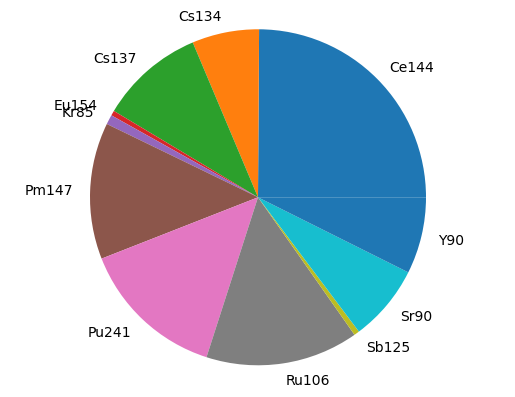

In [19]:
# plot activities in pie chart
# end of cool down period (2 years)

#newBurnact = burnact.copy()
newBurnact = {}
thresh = 10e8

for i, j in burnact.items():
        if j >= thresh:
                newBurnact[i] = j



labels = []
sizes = []
for x, y in newBurnact.items():
    labels.append(x)
    sizes.append(y)
    
print('newburnact',len(newBurnact))
print('burnact',len(burnact)) 
plt.pie(sizes, labels=labels)
plt.axis('equal')
plt.show()

[Material
	ID             =	1000
	Name           =	uo2
	Temperature    =	None
	Density        =	10.96 [sum]
	S(a,b) Tables  
	Nuclides       
	Ac225          =	3.672375146075476e-20 [ao]
	Ac226          =	1.0337546241310894e-22 [ao]
	Ac227          =	8.670200112989942e-17 [ao]
	Ag107          =	6.210283271020561e-13 [ao]
	Ag109          =	2.679103705850285e-06 [ao]
	Ag110_m1       =	2.1981187631798454e-08 [ao]
	Ag111          =	1.6062593991246043e-08 [ao]
	Al27           =	9.997129509790019e-22 [ao]
	Am240          =	1.9468985320816087e-14 [ao]
	Am241          =	5.727486676302197e-07 [ao]
	Am242          =	1.5786253676000415e-09 [ao]
	Am242_m1       =	7.079923306045813e-09 [ao]
	Am243          =	8.422082036830427e-07 [ao]
	Am244          =	5.100930332808986e-11 [ao]
	Am244_m1       =	3.297530020710133e-11 [ao]
	Ar36           =	9.916328809889692e-22 [ao]
	Ar38           =	9.99472188653483e-22 [ao]
	Ar40           =	1.0043176406636656e-21 [ao]
	As74           =	1.1142021550163705e-15 [a

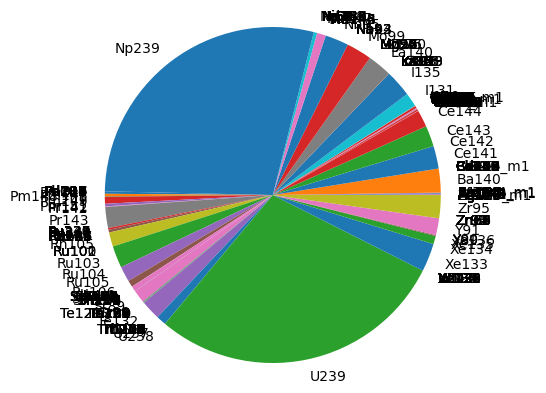

In [22]:
## Unsure this is working for the alternative Time step

# it doesn't but, for some reason, this is because the original "materials.xml" file was overwritten,
# presumably, when we did the BCM search.  If you re-create the original materials.xml file
# by re-running the materials definition plot at the top of the notebook it appears to work.


# get activity at end of power cycle at start of cooldown
burned_mats2 = r.export_to_materials(burnup_index=2)
burned_mats2.export_to_xml('BurnedMaterials2.xml')
print(burned_mats2)
mat_tree2 = et.parse('BurnedMaterials2.xml')
root2 = mat_tree2.getroot()
i=0
for child in root:
    if child.attrib['name']=='uo2':
        uo2_elem2 = root2[i]
    i+=1
    
uo2_elem2.set('id',23+1)
burned_uo2_2 = openmc.Material.from_xml_element(uo2_elem2)

print('Target material activity is %5.3g Bq/g ' % burned_uo2_2.get_activity())
burnact2 = burned_uo2_2.get_activity(by_nuclide=True)
print(burnact2)
labels2 = []
sizes2 = []
for x, y in burnact2.items():
    labels2.append(x)
    sizes2.append(y)
    
plt.pie(sizes2, labels=labels2)
plt.axis('equal')
plt.show()

In [23]:
print(burnact2)

{'Ac225': 0.029461764796998073, 'Ac226': 0.0006776984291484798, 'Ac227': 0.08746861884232379, 'Ag107': 0.0, 'Ag109': 0.0, 'Ag110_m1': 706057493.7389066, 'Ag111': 17297013636.451828, 'Al27': 0.0, 'Am240': 73790.85894294965, 'Am241': 29080350.14703936, 'Am242': 18973153743.799004, 'Am242_m1': 1102886.6897382075, 'Am243': 2509993.30048739, 'Am244': 972413497.9150859, 'Am244_m1': 14651754081.198763, 'Ar36': 0.0, 'Ar38': 0.0, 'Ar40': 0.0, 'As74': 503.0235117990503, 'As75': 0.0, 'Au197': 0.0, 'B10': 0.0, 'B11': 0.0, 'Ba130': 0.0, 'Ba132': 0.0, 'Ba133': 2368.049961658617, 'Ba134': 0.0, 'Ba135': 0.0, 'Ba136': 0.0, 'Ba137': 0.0, 'Ba138': 0.0, 'Ba140': 525919982172.6785, 'Be9': 0.0, 'Bi209': 5.204111916583691e-22, 'Bk246': 7.727561002938866e-09, 'Bk247': 3.48410000796426e-09, 'Bk248': 3.656137278067073e-06, 'Bk249': 24.802349276164545, 'Bk250': 91.97343547163152, 'Br79': 0.0, 'Br81': 0.0, 'Ca40': 0.0, 'Ca42': 0.0, 'Ca43': 0.0, 'Ca44': 0.0, 'Ca46': 0.0, 'Ca48': 9.535756031709572e-25, 'Cd106': 0.0